In [1]:
# !pip install hurst
# !pip install arch
# !pip install bspline

In [2]:
import sys
!{sys.executable} --version
# !pip install bspline

import os
import math
from math import log
# import pickle
import numpy as np
from hurst import compute_Hc
from arch import arch_model
from IPython.display import display
import matplotlib.pyplot as plt

import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from IPython.display import display

%matplotlib inline

# import function libraries for calculating value at risk and computing backtesting statistics

# from quantile_functions import *
# from VaR_backtest_tests import *

# prices = pickle.load(open('stock_prices.pkl','rb'))

# # convert from prices to returns
# returns = dict()
# for k in list(prices.keys()):
#     returns[k] = get_stock_log_returns(prices[k])

Python 3.10.7


# download price history

In [3]:
companies, tickers = ['Meta'],['META']

tickers_df = yf.download(tickers, 
                      start='2017-01-01', 
                      end='2023-01-22', 
                      progress=False, auto_adjust=True)
display(tickers_df.head())
display(tickers_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,116.029999,117.839996,115.510002,116.860001,20663900
2017-01-04,117.550003,119.660004,117.290001,118.690002,19630900
2017-01-05,118.860001,120.949997,118.320000,120.669998,19492200
2017-01-06,120.980003,123.879997,120.029999,123.410004,28545300
2017-01-09,123.550003,125.430000,123.040001,124.900002,22880400


,Open,High,Low,Close,Volume
Date,,,,,
2023-01-13,134.970001,137.389999,134.839996,136.979996,22410700
2023-01-17,136.179993,136.750000,134.250000,135.360001,21147600
2023-01-18,135.809998,137.250000,132.800003,133.020004,20215500
2023-01-19,132.490005,137.449997,132.139999,136.149994,28625200
2023-01-20,135.889999,139.940002,134.610001,139.369995,28643100


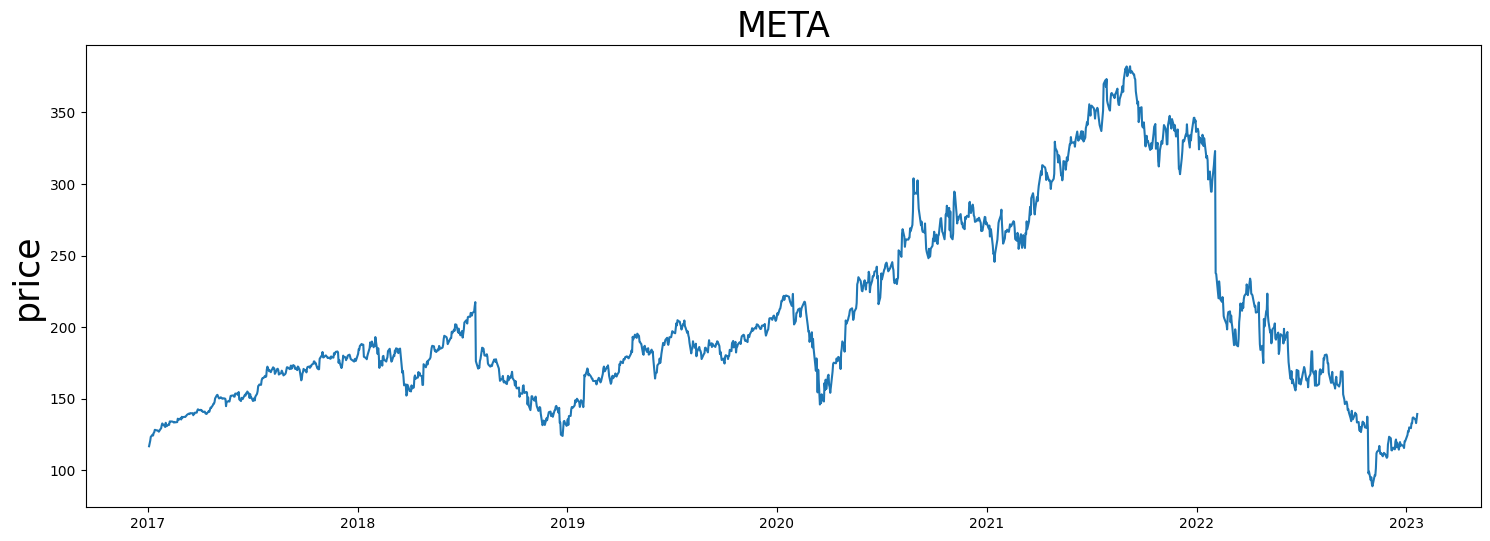

In [4]:
ticker = tickers[0]
prices = {ticker: tickers_df['Close']}

plt.figure(figsize=(18,6))
plt.plot(prices[ticker])
plt.title(ticker, fontsize=25)
plt.ylabel('price', fontsize=25)             
plt.show()

# plot daily returns

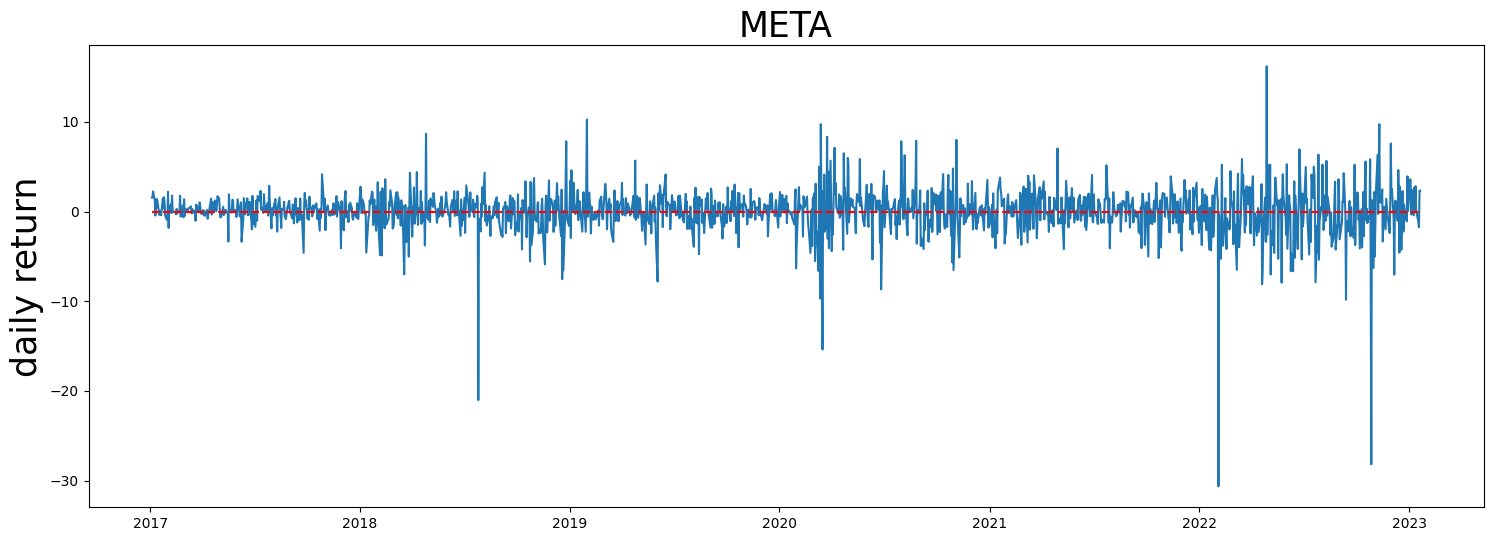

In [5]:
returns = {ticker: tickers_df['Close'].apply(log).diff()[1:]}
train = returns[ticker] * 100
train2 = train * train

plt.figure(figsize=(18,6))
plt.plot(train)
plt.title(ticker, fontsize=25)
plt.plot([train.index[0], train.index[-1]], [0,0], '--',color='red')
plt.ylabel('daily return', fontsize=25) 
plt.show()

# Historical distribution of returns

In [6]:
p = 0.05

nonparametric 95.0% Value at Risk = -3.9320


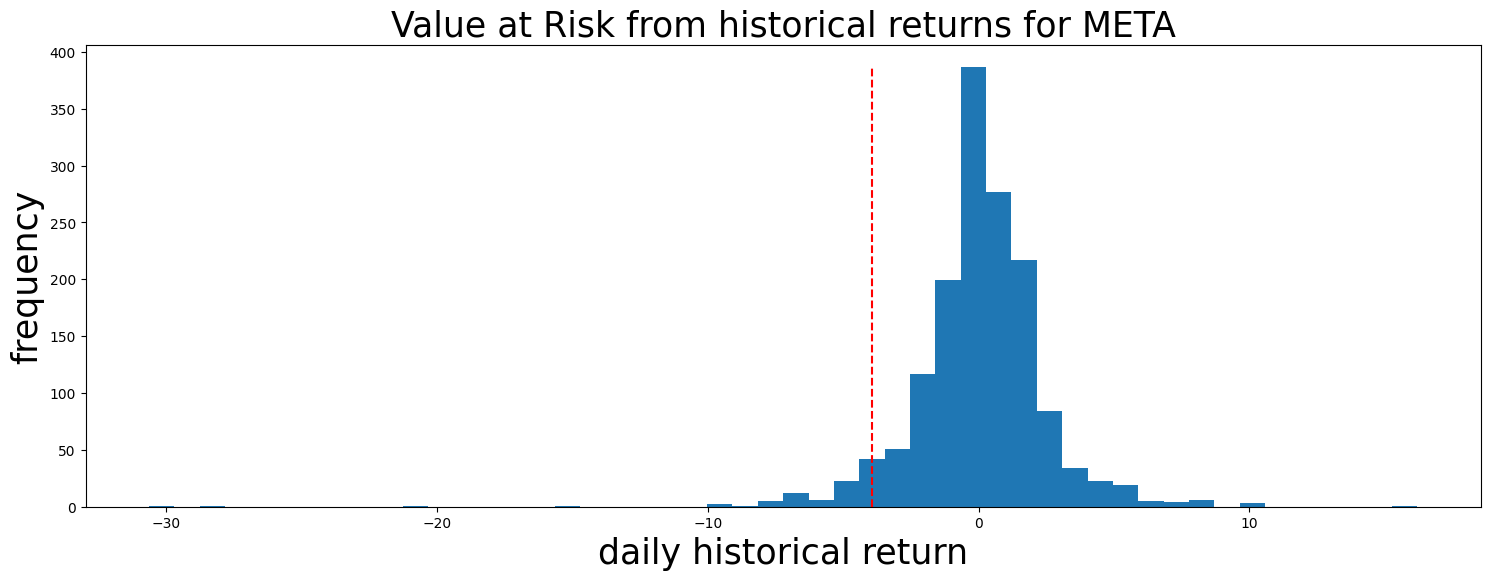

In [7]:
plt.figure(figsize=(18,6))
hist = plt.hist(train,50)
plt.title(f'Value at Risk from historical returns for {ticker}', fontsize=25)
plt.xlabel('daily historical return', fontsize=25)
plt.ylabel('frequency', fontsize=25)

VaRcutoff = np.quantile(train, p)
print(f"nonparametric {100 - 100 * p}% Value at Risk = {VaRcutoff:0.4f}")
plt.plot([VaRcutoff,VaRcutoff],[0, max(hist[0])], '--',color='red')

plt.show()

# VaR assuming a Gaussian distribution

daily return mean = 0.011574 and standard deviation = 2.584522

cutoff = -1.6449 * 2.5845 at probability 0.05

parametric 95.0% Value at Risk = -4.2512


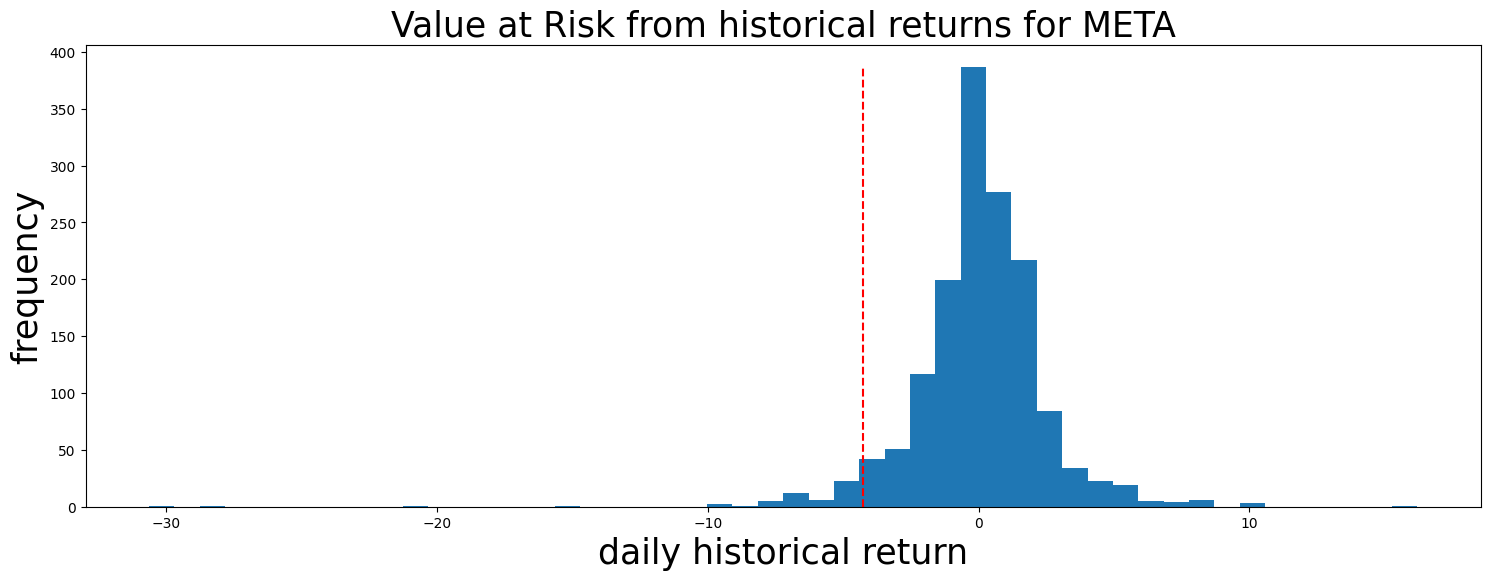

In [8]:
from scipy.stats import norm

mu, sigma = np.mean(train), np.std(train)
print(f"daily return mean = {mu:0.6f} and standard deviation = {sigma:0.6f}")

plt.figure(figsize=(18,6))
hist = plt.hist(train,50)
plt.title(f'Value at Risk from historical returns for {ticker}', fontsize=25)
plt.xlabel('daily historical return', fontsize=25)
plt.ylabel('frequency', fontsize=25)

VaRcutoff = norm.ppf(p) * sigma
print(f"\ncutoff = {norm.ppf(p):0.4f} * {sigma:0.4f} at probability {p}")
print(f"\nparametric {100 - 100 * p}% Value at Risk = {VaRcutoff:0.4f}")
plt.plot([VaRcutoff,VaRcutoff],[0, max(hist[0])], '--',color='red')

plt.show()

# MA: Fit interval moving average value at risk
## note abrupt drop and rise in VaR in late 2018

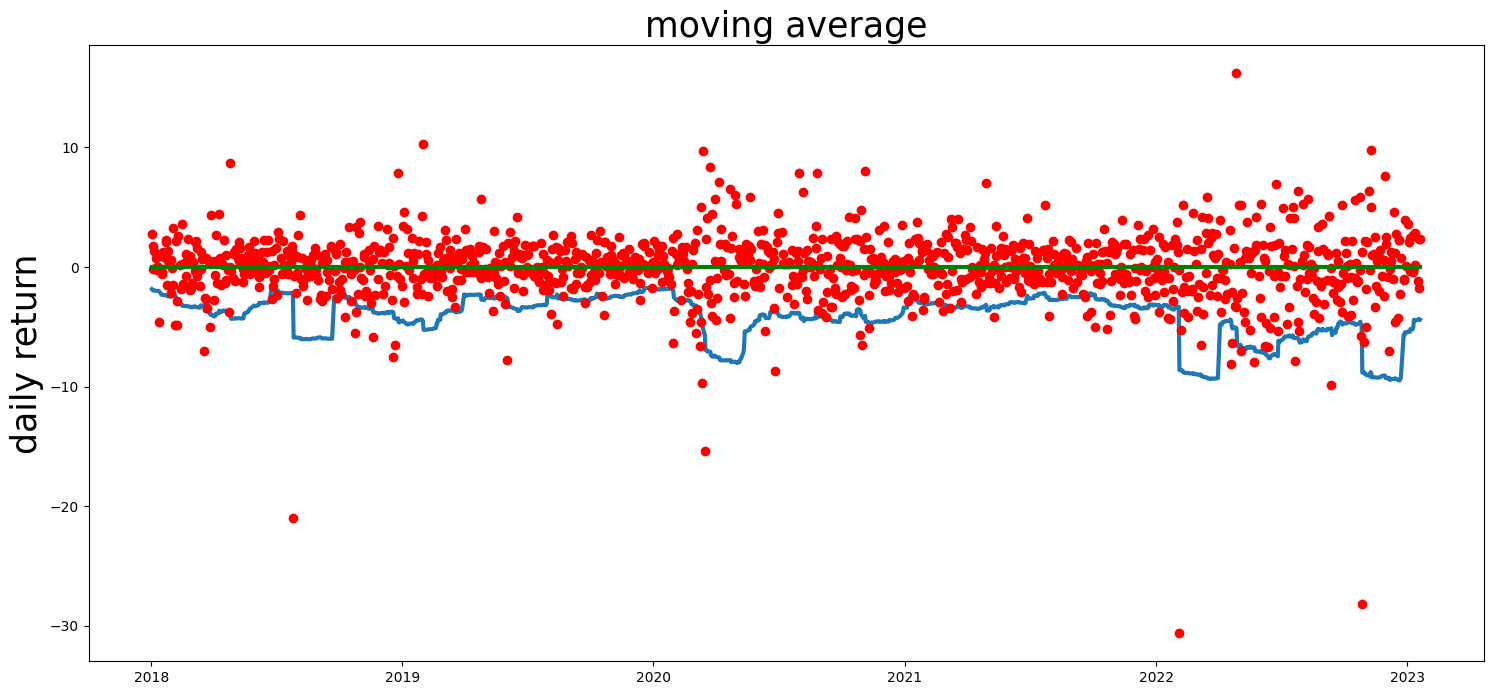

In [9]:
history_n = 40  # length of window for calculating historical volatility
MAVaR = [-1.645 * np.sqrt(np.mean(train2[i:i+history_n])) for i,_ in enumerate(train2[:-history_n])]

MAVaR_df = pd.DataFrame(MAVaR[:], index=pd.DataFrame(train).index[40:], columns=['VaR'])
plt.figure(figsize=(18,8))
start_date = '2018-01-01'
plt.plot(MAVaR_df[start_date:]['VaR'],linewidth=3)
plt.plot(pd.DataFrame(train[start_date:]), 'ro')
plt.plot(pd.DataFrame([0,0],index=MAVaR_df[start_date:].index[[0,-1]]), 'g-',linewidth=3)
plt.title("moving average", fontsize=25)
plt.ylabel('daily return', fontsize=25)
plt.show()

# EWMA: exponential weighted moving average volatiity

$$\sigma^2_n = (1 - \lambda) u^2_{n-1} + \lambda \sigma^2_{n-1}$$ 

In [10]:
train2 = train * train

wt = .94
vol = train2[0]
vol_history = [0,vol]  # move everything forward one day

print(train2[0])
print(train2[1])

for v in train2[1:]:
    print(vol)
    print(v)
    break
    vol = wt * vol + (1 - wt) * v
    vol_history.append(vol)
    
vol_df = pd.DataFrame(vol_history[:-1], index=train.index, columns=['vol'])
vol_df['EWMA'] = [-1.64 * math.sqrt(x) for x in vol_df['vol']]

plt.figure(figsize=(18,8))
plt.plot(vol_df['2018-01-01':]['EWMA'], linewidth=3)
plt.plot(pd.DataFrame(train['2018-01-01':]), 'ro')
plt.plot(pd.DataFrame([0,0],index=MAVaR_df[start_date:].index[[0,-1]]), 'g-',linewidth=3)
plt.title('exponential weighted moving average', fontsize=25)
plt.ylabel('daily return', fontsize=25)
plt.show()

2.414428158397999
2.737191326500245
2.414428158397999
2.737191326500245


ValueError: Shape of passed values is (1, 1), indices imply (1522, 1)

# GARCH(1,1) model

$$\sigma^2_n = \omega + \alpha u^2_{n-1} + \beta \sigma^2_{n-1}$$

In [ ]:
train = returns[ticker] * 100

model = arch_model(train, mean='Zero', vol='GARCH', p=1, q=1)
res = model.fit(last_obs='2019-12-31')
print(res.summary())
plt.rc("figure", figsize=(16, 6))
fig = res.plot(annualize='D')
print(res.params, res.tvalues, res._params, res._names)

### GARCH parameters

In [ ]:
display(pd.DataFrame(res.params))
persistence = res.params['alpha[1]'] + res.params['beta[1]']
print(f"\npersistence = {persistence:0.3} (speed of mean reversion see Jorion Fig 9-6 page 229)")
print(f"unconditional variance = {res.params['omega'] / ( 1 - persistence): 0.3}")

In [ ]:
from arch.__future__ import reindexing

forecasts = res.forecast(start='2018-01-01') # .variance['h.1']
cond_mean = forecasts.mean['2018-01-01':]
cond_var = forecasts.variance['2018-01-01':]
q = model.distribution.ppf([p]) 
value_at_risk = pd.DataFrame([-x[0] for x in -cond_mean.values - np.sqrt(cond_var).values * q], 
                             index=train['2018-01-01':].index)
plt.figure(figsize=(18,10))
plt.plot(value_at_risk, linewidth=3)
plt.plot(train['2018-01-01':], 'ro')
plt.plot(pd.DataFrame([0,0],index=MAVaR_df[start_date:].index[[0,-1]]), 'g-',linewidth=3)
plt.title('GARCH(1,1)', fontsize=25)
plt.ylabel('daily return', fontsize=25)
plt.show()